In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np
import random
import numpy as np
import networkx as nx
import pprint as pp
import torch
import torch.nn as nn
import torch.nn.functional as F
import  gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt


In [203]:
class GAT_layer(nn.Module):
    def __init__(self, in_features: int, out_features: int, n_heads: int,
                 is_concat: bool = True,
                 dropout: float = 0.6,
                 leaky_relu_negative_slope: float = 0.2):


        super().__init__()

        self.is_concat = is_concat
        self.n_heads = n_heads

        if is_concat:
            assert out_features % n_heads == 0
            self.n_hidden = out_features // n_heads
        else:
            self.n_hidden = out_features


        self.linear = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
        self.attn = nn.Linear(self.n_hidden * 2, 1, bias=False)
        self.activation = nn.LeakyReLU(negative_slope=leaky_relu_negative_slope)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):

        n_nodes = h.shape[0]

        g = self.linear(h).view(n_nodes, self.n_heads, self.n_hidden)


        g_repeat = g.repeat(n_nodes, 1, 1)

        g_repeat_interleave = g.repeat_interleave(n_nodes, dim=0)

        g_concat = torch.cat([g_repeat_interleave, g_repeat], dim=-1)
        g_concat = g_concat.view(n_nodes, n_nodes, self.n_heads, 2 * self.n_hidden)


        e = self.activation(self.attn(g_concat))
        e = e.squeeze(-1)

        assert adj_mat.shape[0] == 1 or adj_mat.shape[0] == n_nodes
        assert adj_mat.shape[1] == 1 or adj_mat.shape[1] == n_nodes
        assert adj_mat.shape[2] == 1 or adj_mat.shape[2] == self.n_heads
        e = e.masked_fill(adj_mat == 0, float('-inf'))
        a = self.softmax(e)

        a = self.dropout(a)
        attn_res = torch.einsum('ijh,jhf->ihf', a, g)
        if self.is_concat:
            return attn_res.reshape(n_nodes, self.n_heads * self.n_hidden)
        else:
            return attn_res.mean(dim=1)




In [204]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, noutput,dropout, alpha_leaky_relu,n_heads,training=True):
        super(GAT, self).__init__()
        self.elu = nn.ELU()
        self.attentions1 = GAT_layer(nfeat, nhid, n_heads=n_heads, dropout=dropout, leaky_relu_negative_slope=alpha_leaky_relu, is_concat=True)
        self.attentions2 = GAT_layer(nhid , nhid, n_heads=n_heads, dropout=dropout, leaky_relu_negative_slope=alpha_leaky_relu, is_concat=True)
        self.attentions3 = GAT_layer(nhid , nhid, n_heads=n_heads, dropout=dropout, leaky_relu_negative_slope=alpha_leaky_relu, is_concat=True)
        self.training = training
        self.output_layer = GAT_layer(nhid , noutput, n_heads=1, dropout=dropout, leaky_relu_negative_slope=alpha_leaky_relu, is_concat=False)

    def forward(self, x, adj):
        x = self.attentions1(x, adj)
        x = self.elu(x)
        x = self.attentions2(x, adj)
        x = self.elu(x)
        x = self.attentions3(x, adj)
        x = self.elu(x)
        x = self.output_layer(x, adj)

        return x

In [205]:
from itertools import combinations, groupby
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [260]:
# create a random graph
num_nodes = 5000
seed = 10
probability = 0.01
G = gnp_random_connected_graph(num_nodes,probability)

# select two random nodes, one for source and one for target
source = np.random.randint(0, num_nodes)
target = np.random.randint(0, num_nodes)
# create a list of all nodes in the graph
nodes = np.array(G.nodes())
print(f"source: {source}, target: {target}")
print(f"nodes: {nodes}")
# get the shortest path between the source and target nodes
path = nx.shortest_path(G, source=source, target=target)
print(f"path: {path}")
# put the shortest path in red
node_colours = ['skyblue' if not node in path else 'red' for node in nodes]

#nx.draw(G, with_labels=True, node_color=node_colours)

source: 1940, target: 3610
nodes: [   0    1    2 ... 4997 4998 4999]
path: [1940, 4707, 267, 3610]


In [261]:
# prepare the output of the model. The output is a vector of size 40, one for each node in the graph. 0 if the node is not in the shortest path, 1 if it is.
output = np.zeros(len(nodes))
output[path] = 1
print(f"output: {output}")
# input is one on the source node and on the target node, 0 on the others
input = np.zeros((len(nodes),1))
input[source] = 1
input[target] = 1


output: [0. 0. 0. ... 0. 0. 0.]


In [262]:
# import gat from torch

model= GAT(nfeat=1,
            nhid=32,
            noutput=2,
            dropout=0,
            alpha_leaky_relu=0.2,
            n_heads=8,
            training=True)
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
adj_matrix = nx.adjacency_matrix(G).todense()
n_power = 1
# put adj_matrix power n_power. Replace all > 0 value with 1
adj_matrix = adj_matrix + np.identity(adj_matrix.shape[0])
adj_matrix = np.where(np.linalg.matrix_power(adj_matrix, n_power) > 0, 1, 0)

print(adj_matrix)


[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]]


In [263]:
input = torch.tensor(input, dtype=torch.float32, requires_grad=False)
print(f"input: {input.shape}")
target = torch.tensor(output, dtype=torch.long, requires_grad=False)
print(f"target: {target.shape}")
# add indentiy matrix to adj_matrix
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32, requires_grad=False).unsqueeze(-1)
print(f"adj_matrix: {adj_matrix.shape}")
# adj_matrix  to matri
#x


input: torch.Size([5000, 1])
target: torch.Size([5000])
adj_matrix: torch.Size([5000, 5000, 1])


In [264]:
# reduce the lr
opitmizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion
# use it in the training loop


CrossEntropyLoss()

In [265]:
#optimizer.state['lr'] = 0.00025

In [266]:
loss_list = []
for epoch in range(30000):
    # forward
    print(input.shape)
    output_model = model(input, adj_matrix)

    # compute loss
    loss = criterion(output_model, target)
    loss_list.append(loss.item())
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    print(f"epoch: {epoch}, loss: {loss.item()}")

torch.Size([5000, 1])
epoch: 0, loss: 0.6931473612785339
torch.Size([5000, 1])
epoch: 1, loss: 0.6930102109909058
torch.Size([5000, 1])
epoch: 2, loss: 0.6928319931030273
torch.Size([5000, 1])


KeyboardInterrupt: 

In [255]:
# print all parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

attentions1.linear.weight tensor([[ 1.2958],
        [ 1.0598],
        [-0.8293],
        [ 0.4813],
        [-0.3819],
        [ 1.1800],
        [-0.8286],
        [ 0.5223],
        [ 0.8352],
        [-1.0516],
        [-0.9241],
        [-0.5272],
        [ 0.6674],
        [-0.6561],
        [ 0.6634],
        [ 0.4356],
        [ 0.7939],
        [-0.8193],
        [ 0.1876],
        [-1.1440],
        [ 1.0209],
        [ 1.0397],
        [-1.6295],
        [-1.4011],
        [-0.8521],
        [-0.7718],
        [ 0.6099],
        [-0.9791],
        [-1.3594],
        [-0.7025],
        [ 0.7451],
        [ 0.7318]])
attentions1.attn.weight tensor([[ 0.3594,  0.3345, -0.0067, -0.4759,  0.8360,  0.5905, -0.8197, -0.4864]])
attentions2.linear.weight tensor([[ 0.4219,  0.4055, -0.1811,  ..., -0.2195,  0.4171,  0.2799],
        [-0.4731, -0.3759,  0.6527,  ...,  0.2278, -0.0501, -0.1286],
        [ 0.2277,  0.2867, -0.1988,  ..., -0.4297,  0.1566,  0.1822],
        ...,
        [

In [256]:
with torch.no_grad():
    output_model = model(input, adj_matrix)
    print(output_model)
    print(torch.argmax(F.softmax(output_model, dim=1), dim=1))
output_model = torch.argmax(F.softmax(output_model, dim=1), dim=1).numpy()
target_to_print = target.numpy()
print(input.squeeze().numpy())
print(output_model)
print(target_to_print)


tensor([[  4.3427,  -9.1796],
        [  6.2695, -11.6297],
        [  5.1663, -11.0289],
        [  5.5348, -11.0356],
        [  5.6426, -11.3453],
        [  0.0000,   0.0000],
        [ -5.9039,   0.8494],
        [  5.3131, -11.2581],
        [  4.9907, -10.8141],
        [  4.6073,  -9.9938],
        [  4.7500, -10.2126],
        [  4.1893,  -9.8344],
        [  6.4356, -11.8153],
        [  4.3309, -10.0515],
        [  5.1437, -10.7353],
        [  5.6458, -10.9323],
        [  4.9527, -10.5972],
        [  5.5743, -11.0817],
        [  4.0502,  -9.8736],
        [  4.8712, -10.6320],
        [  3.9271,  -9.6474],
        [  5.1626, -11.1194],
        [  5.2313, -10.6687],
        [  4.7913, -10.2853],
        [  5.2638, -10.6622],
        [  5.3568, -10.9442],
        [  5.5561, -10.9101],
        [  0.0000,   0.0000],
        [  3.8450,  -9.7463],
        [  5.2098, -10.7846],
        [  3.4953,  -8.7274],
        [  5.1758, -10.8109],
        [  4.7229, -10.2686],
        [ 

In [257]:
# compute the accuracy between the output of the model and the target
accuracy = np.sum(output_model == target_to_print) / len(output_model)
# compare how much the model output has 1 compared to the target
print(f"output: {np.sum(output_model)}")
print(f"target: {np.sum(target_to_print)}")

print(f"accuracy: {accuracy}")


output: 4
target: 4
accuracy: 1.0


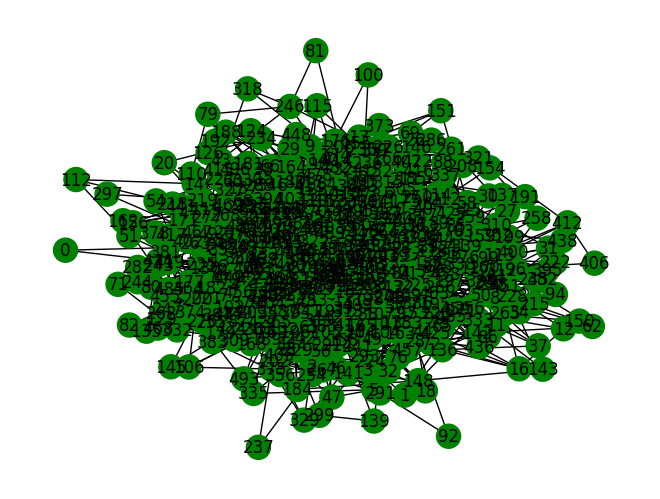

In [258]:
# plot the graph with the output of the model. Put in green the value found in output that are the same of the model output, in red the value that are different
node_colours = ['green' if output_model[i] == target_to_print[i] else 'red' for i in range(len(nodes))]
nx.draw(G, with_labels=True, node_color=node_colours)